## Домашнее задание


1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [18]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [19]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

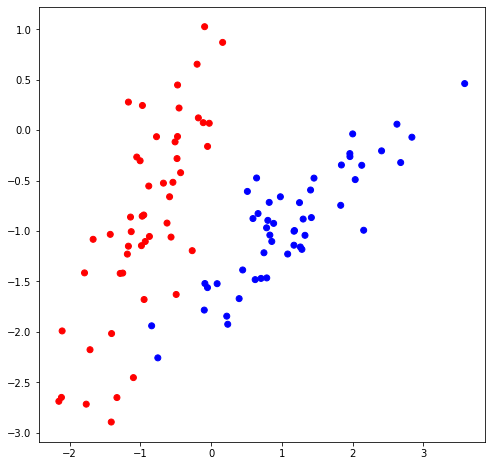

In [20]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [21]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [22]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction       

In [23]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [24]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [25]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [26]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, n_features, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [27]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, n_features, min_leaf):

    quality, t, index = find_best_split(data, labels, n_features, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, min_leaf)
    false_branch = build_tree(false_data, false_labels, n_features, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [28]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [29]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [30]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [15]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [31]:
def result(n_features, min_leaf, train_data=train_data,test_data=test_data,
              train_labels=train_labels,test_labels=test_labels):
    tree = build_tree(train_data, train_labels, n_features, min_leaf)
    train_res = predict(train_data, tree)
    result = predict(test_data, tree)
    train_acc = accuracy_metric(train_labels, train_res)
    test_acc = accuracy_metric(test_labels, result)
    print(f'Обучение: train: {train_acc:.3f}, test: {test_acc:.3f}')
    print(f'Характеристики: {n_features}, Мин. лист: {min_leaf}')

In [32]:
for i in range(3,6):
    for j in range(5,7):
        result(i, j)
        print()

Обучение: train: 98.571, test: 100.000
Характеристики: 3, Мин. лист: 5

Обучение: train: 98.571, test: 100.000
Характеристики: 3, Мин. лист: 6

Обучение: train: 98.571, test: 100.000
Характеристики: 4, Мин. лист: 5

Обучение: train: 98.571, test: 100.000
Характеристики: 4, Мин. лист: 6

Обучение: train: 98.571, test: 100.000
Характеристики: 5, Мин. лист: 5

Обучение: train: 98.571, test: 100.000
Характеристики: 5, Мин. лист: 6



Вывод: Чем больше признаков и минимальное количество листьев, тем хуже качество тестовых данных. Модель переобучается

In [33]:
data, labels = datasets.make_regression(n_features=2, random_state=5)

In [34]:
data[:5]

array([[ 1.15220477, -0.57751323],
       [ 1.14720208,  0.24981732],
       [ 1.58248112,  0.10960984],
       [-0.32986996,  0.18760323],
       [-0.10061435, -0.33633626]])

In [35]:
labels[:5]

array([ 62.06381583,  77.52011913, 102.45299266, -17.34404931,
       -12.7935693 ])

In [36]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [37]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        objects = []  # сформируем список объектов в листе
        for label in self.labels:
            objects.append(label)
        #  найдем среднее    
        objects = np.array(objects)
        prediction = objects.mean()
        return prediction   

In [38]:
def means(labels):
    objects = []  
    for label in labels:
        objects.append(label)
    objects = np.array(objects)
    pred = objects.mean()
    return np.mean((labels - pred) ** 2)

In [39]:
def quality(left_labels, right_labels, current_mean):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_mean - p * means(left_labels) - (1 - p) * means(right_labels)

In [40]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [41]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_mean = means(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_mean)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [42]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [43]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [44]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = classify_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [45]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                labels, test_size = 0.3, random_state = 1)

In [46]:
my_tree = build_tree(train_data, train_labels)

In [47]:
train_res = predict(train_data, my_tree)

In [48]:
res = predict(test_data, my_tree)

In [49]:
def mse_(labels, res):
    return np.mean((labels - res) ** 2)

In [50]:
mse_(train_labels, train_res)

218.57831019366

In [51]:
mse_(test_labels, res)

496.16389376803176

In [52]:
def r_2(labels, res):
    return (1 - np.sum((res - labels) ** 2) / np.sum((labels - np.mean(labels))**2))

In [53]:
r_2(train_labels, train_res)

0.9473030504970069

In [54]:
r_2(test_labels, res)

0.8558102546515577